
**Team:** 3<br>
**Date created:** 2024/03/22<br>
**Last modified:** 2024/03/24<br><br>

本組針對 2024/1/1~2024/3/20 於 PTT的股票版(Stock) 中有關 00940 ETF 的文集進自然語言處理。<br>

前半段使用中研院提供的CKIP自然語言處理工具包，再透過CKIP的NER產出針對00940中具有關鍵字「元大」的sentence，使用SnowNLP進行情緒分析，並產出正面文字雲。<br>

後半段則使用jieba作為中文斷詞工具，並搭配lexicon-base進行情緒分析，並產出負面文字雲。

## **大綱**


0. 套件載入
1. 利用CKIP進行自然語言處理
    + 1.1 CKIP 標註
    + 1.2 探索分析 - NER長條圖
    + 1.3 探索分析 - POS長條圖
2. 利用SnowNLP進行情緒分析
    + 2.1 產出情緒分布的盒狀圖
    + 2.2 產出正面文字雲
3. 利用jieba進行前資料處理
    + 3.1 詳細斷詞、斷句處理
    + 3.2 產生文字雲
4. 利用lexicon-base進行情緒分析
    + 4.1 正負向情緒詞彙頻率折線圖
    + 4.2 文章為單位的情緒分析
    + 4.3 情緒代表字長條圖
    + 4.4 產出負面文字雲

## **0. 套件載入**

In [ ]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install -U ckiptagger\[tf,gdown\]
# %pip install wordcloud SnowNLP

In [1]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
import jieba.analyse

## **1.利用CKIP進行自然語言處理**



### 1.1 CKIP 標註

#### CKIP 安裝

- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger


In [ ]:
data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=322425f7-6f4f-4126-a565-70fe22634314
To: c:\Users\User\SMA_2024S - 複製\week5\data.zip
100%|██████████| 1.88G/1.88G [35:39<00:00, 877kB/s]  


透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [8]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\User\anaconda3\envs\SMA\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\User\anaconda3\envs\SMA\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\User\anaconda3\envs\SMA\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCel

#### CKIP 處理 Code

資料來源：
+ 工作流程平台蒐集PTT 股票版(Stock)文章
+ 搜尋關鍵字:「00940」、「940」(227筆)
+ 去除關鍵字:「9940」、「信義」
+ 時間: 2024-01-01 ~ 2024-03-20

In [2]:
## 讀取文章
df = pd.read_csv('raw_data/zh/00940.csv')

定義文字清理的相關function

In [9]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

CKIP 處理相關function

In [4]:
# 自定義辭典
with open('dict/user_dict.txt', encoding='utf-8') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'元大': 500.0, '長榮': 500.0, '正二': 500.0, '韭菜': 500.0, '散戶': 500.0, '漲停': 500.0, '跌停': 500.0, '開盤': 500.0, '當沖': 500.0, '聯電': 500.0, '神基': 500.0, '大戶': 500.0, '美債': 500.0}), (3, {'940': 500.0, '944': 500.0, '919': 500.0, '939': 500.0, '高股息': 500.0, '聯發科': 500.0, '中美晶': 500.0, '殖利率': 500.0, '成分股': 500.0, '台積電': 500.0, '元大金': 500.0, '巴菲特': 500.0, '現金流': 500.0, '標準差': 500.0, '手續費': 500.0, '經理費': 500.0}), (4, {'AVGO': 500.0, '台灣價值': 500.0}), (5, {'00940': 500.0, '00944': 500.0, '00919': 500.0, '00939': 500.0, '左手換右手': 500.0}), (8, {'元大台灣價值高息': 500.0})]


In [10]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [6]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['原文標題'], ['元大加入月配息戰場', '發行價元有收益平準金月號募集'], ['原文連結'], ['//////'], ['發布時間']]
['原文標題', '元大加入月配息戰場', '發行價元有收益平準金月號募集', '原文連結', '//////']


In [11]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 255.05085372924805


In [12]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 195篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 182篇有抓到ner

total posts numbers: 227
posts have NER: 214


#### CKIP 處理結果 : 將文章存成 csv

In [13]:
# 將文章存成csv
pos_table.to_csv('raw_data/zh/pos_table_00940.csv', index = False)
entity_table.to_csv('raw_data/zh/entity_table_00940.csv', index = False)
sentence_table.to_csv('raw_data/zh/sentence_table_00940.csv', index = False)

### 1.2 NER 探索分析

#### NER 種類分析 Code

將剛才分析的資料匯入

In [14]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_00940.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_00940.csv") 
sentence_table = pd.read_csv("raw_data/zh/sentence_table_00940.csv") 

查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [15]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
11,ORG,1115
1,DATE,676
13,PERSON,382
4,GPE,354
0,CARDINAL,351
8,MONEY,222
9,NORP,56
10,ORDINAL,47
15,TIME,39
7,LOC,29


C:\Users\User\AppData\Local\Temp\ipykernel_7060\3390866936.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


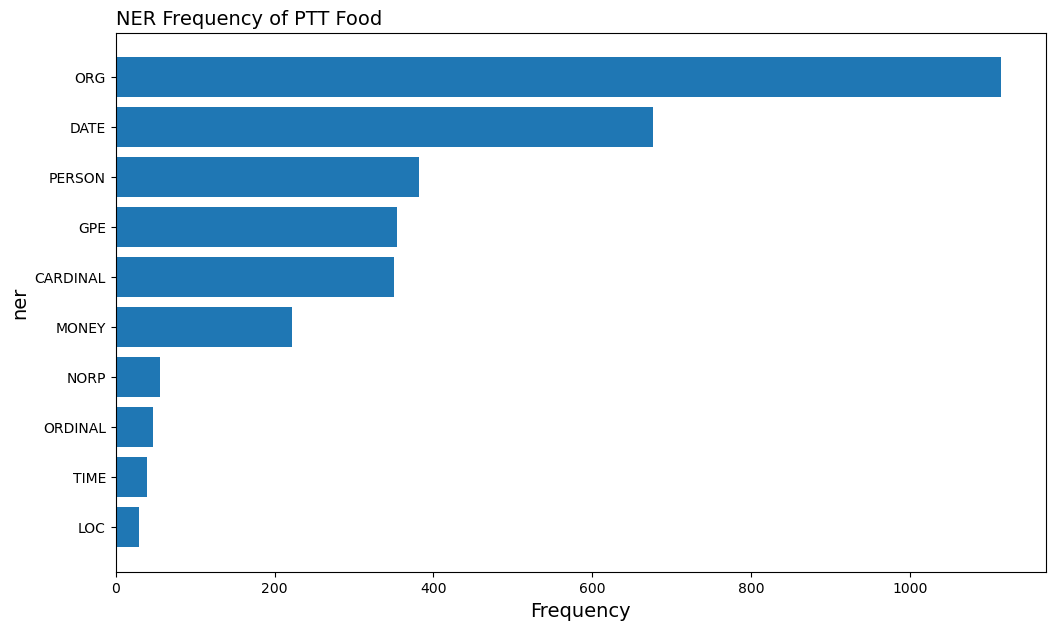

In [16]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### NER 分析結果 1 : 涉及到的民族、宗教、政治團體(NORP)

C:\Users\User\AppData\Local\Temp\ipykernel_7060\528965377.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


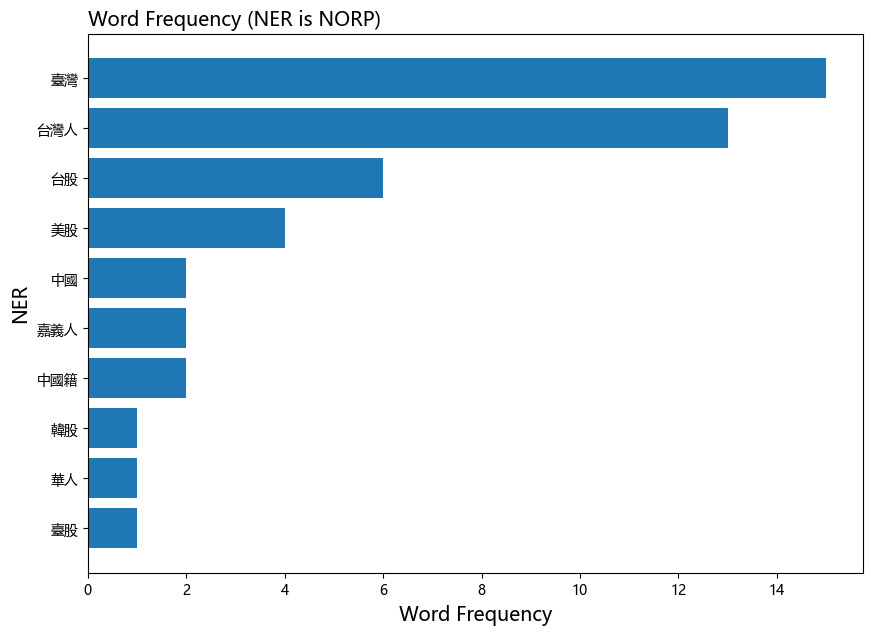

In [17]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial', 'sans-serif'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

結論: 可以看到鄉民討論該張ETF多與「台灣」、「台股」相關，若對該張ETF不熟悉，可推測出它是與台灣國籍相關的ETF，可能是由台灣發行的。

#### NER 分析結果 2 : 涉及到的組織(ORG)

C:\Users\User\AppData\Local\Temp\ipykernel_7060\1412568801.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


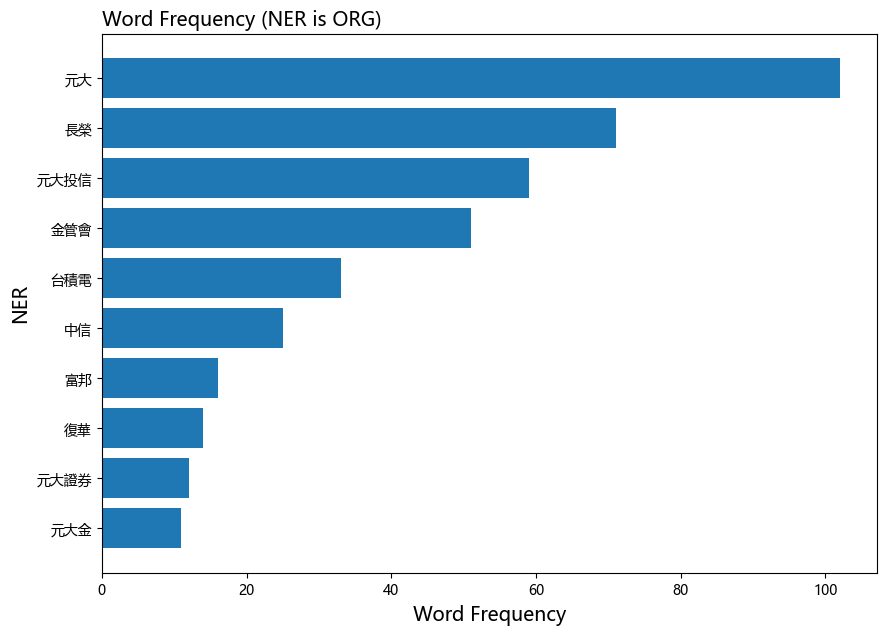

In [18]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial', 'sans-serif'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

結論: 可以看到在多數的ETF討論之中，「元大」、「長榮」是多數文章會介紹到的一環，也間接反映出讀者對於該張ETF的發行機構以及其成分股相當關注。

下面找出「元大」相關文章，與後續SnowNLP情緒分析一起做探索

In [19]:
keyword_list = ['元大']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

元大：82篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,kiversonx17,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC...",118.165.210.174,2024-01-28 02:04:10,ptt
4,5,https://www.ptt.cc/bbs/Stock/M.1707120349.A.22...,[情報]0205上市外資買賣超排行,2024-02-05 16:05:46,paidzou,Stock,1. 標題：0205 上市外資買賣超排行\n\n2. 來源：TWSE\n\n3. 網址：\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""saes0001"", ""...",223.136.192.176,2024-02-06 02:07:31,ptt
7,8,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,[請益]00940的選股邏輯,2024-02-18 17:39:12,humbler,Stock,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""apeople"", ""c...",111.251.198.167,2024-02-19 02:05:29,ptt


### 1.3 POS 探索分析


#### POS 種類分析 Code


看看除了標點符號，大部分的POS都是哪一類

In [20]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,10718
5,D,5203
35,VC,4112
41,VH,2855
6,DE,1647
16,Nb,1646
29,P,1623
25,Nf,1351
38,VE,1327
17,Nc,1287


#### POS 分析結果 : 涉及到的動詞(VERB)


+ 我們可以找出談論00940時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [21]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
407,申購,214
214,投資,166
75,募集,156
419,發布,65
636,連結,63
494,署名,59
425,發行,41
586,買進,39
50,分析,35
669,銷售,30


C:\Users\User\AppData\Local\Temp\ipykernel_7060\3082678158.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


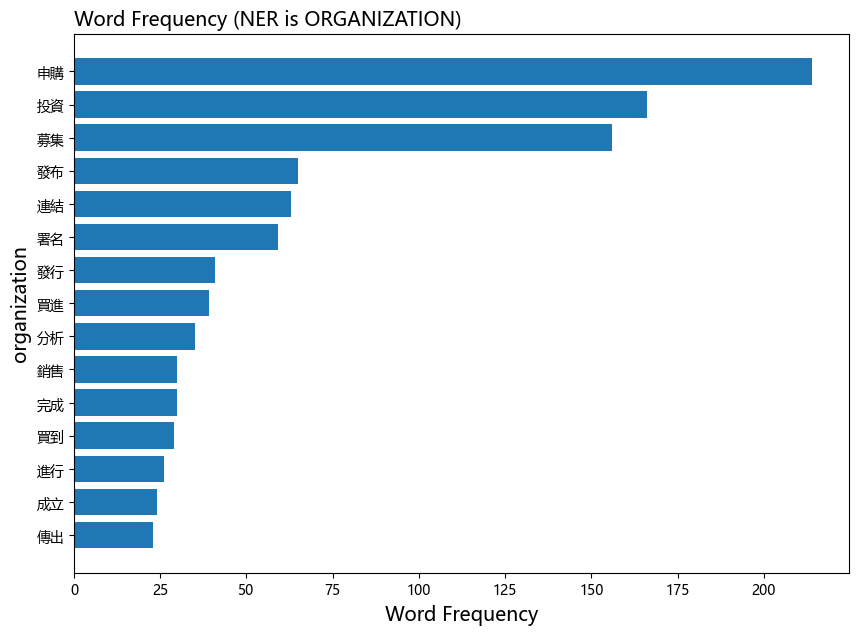

In [22]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial', 'sans-serif'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

結論: 發現在貼文中的動詞，「申購」佔了相當高的頻率，其他還有出現「投資」、「募集」等詞彙，可推測鄉民對於申購ETF的興趣高、投資該ETF的關注度頗高，ETF的募集活動也備受關注。

## **2. 利用 SnowNLP 進行情緒分析**

### 2.1 SnowNLP 分析


#### SnowNLP 分析 Code

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

使用先前NER得到的「元大」相關文章，看看元大相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [23]:
from snownlp import SnowNLP

In [24]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_00940.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
0,1,原文標題,2024-01-27 11:40:33,ptt
1,1,元大加入月配息戰場,2024-01-27 11:40:33,ptt
2,1,發行價元有收益平準金月號募集,2024-01-27 11:40:33,ptt


In [44]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,原文標題,2024-01-27 11:40:33,ptt,0.062369
1,1,元大加入月配息戰場,2024-01-27 11:40:33,ptt,0.045495
2,1,發行價元有收益平準金月號募集,2024-01-27 11:40:33,ptt,0.065946


In [26]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    3.221000e+03
mean     4.039492e-01
std      3.103272e-01
min      3.465987e-07
25%      1.113206e-01
50%      3.771781e-01
75%      6.557043e-01
max      9.999966e-01
Name: sentimentValue, dtype: float64

#### SnowNLP 分析結果 1 : 情緒值箱型圖

<AxesSubplot:>

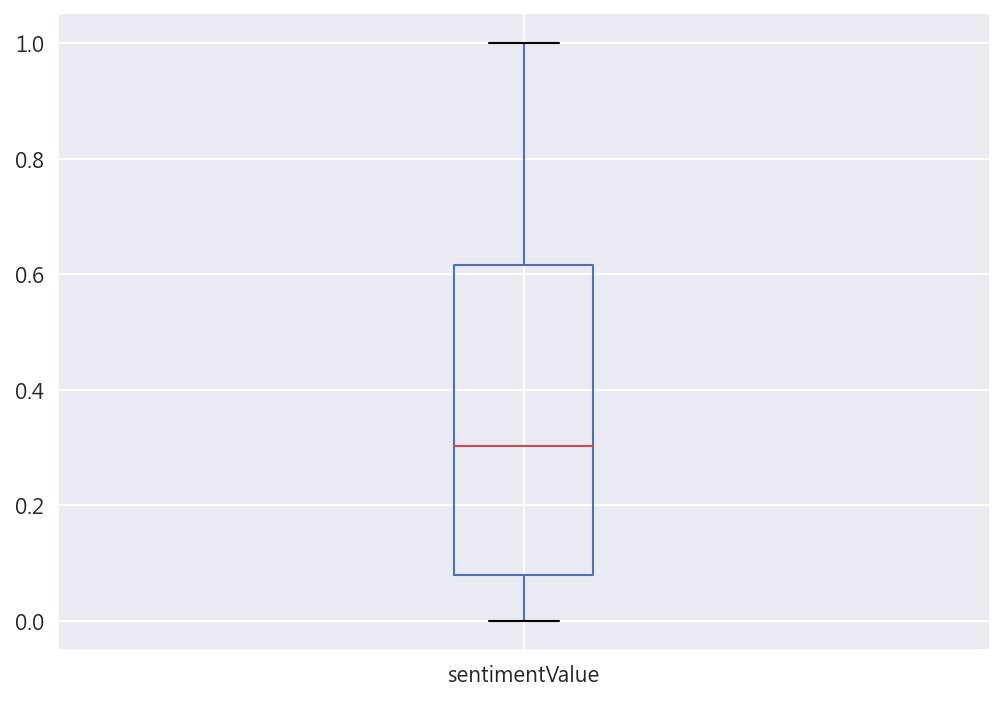

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

#### SnowNLP 分析結果 2 : 情緒值折線圖

將每個月的情緒分數取平均，並轉換時間格式為年月

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2024-01,0.249819
1,2024-02,0.310055
2,2024-03,0.378830


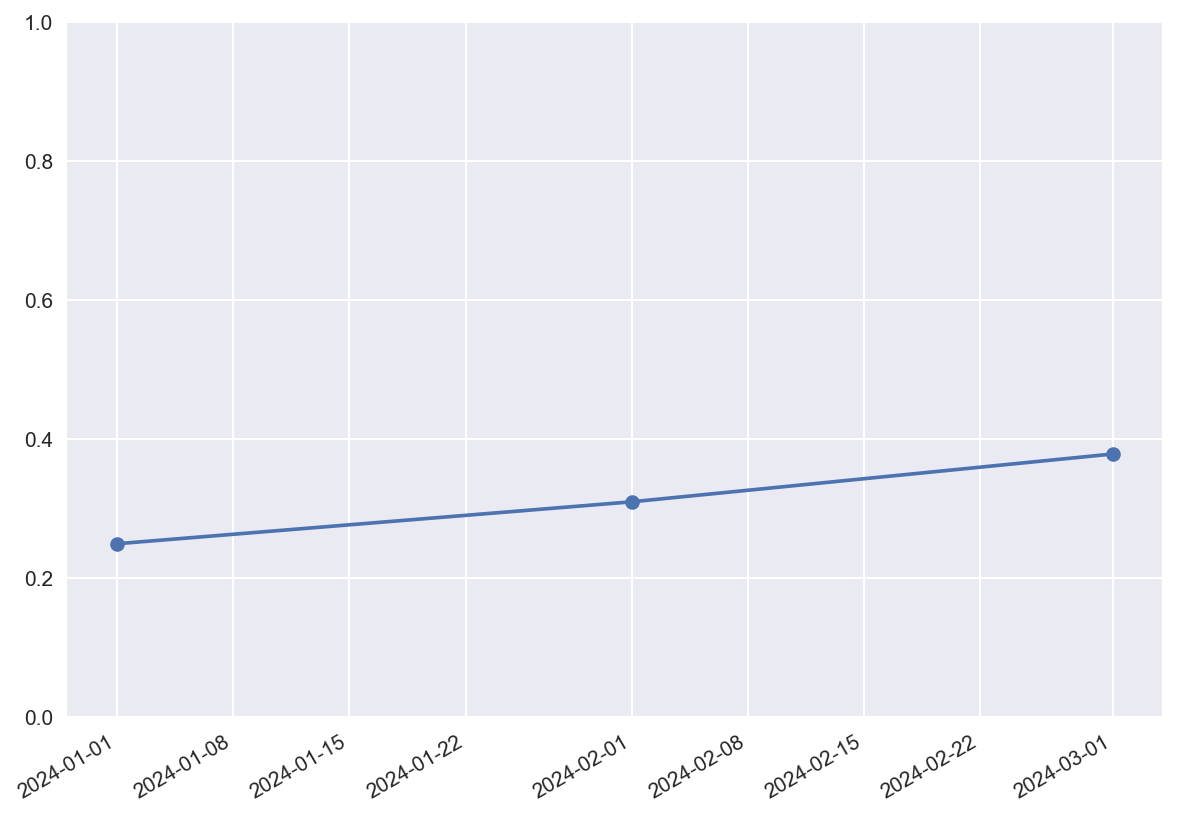

In [ ]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

結論: 從上圖中發現大部分天數的情緒值都在0.2~0.4之間，偏低，推測是因為PTT股票板上多數為負面消息報導或投資建議的討論。我們挑出 2024年03月 來分析。

### 2.2 詞彙探索分析


#### 詞彙探索分析 Code

從上圖中可以發現 2024年03月 的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [30]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2024-03']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
912,25,記者署名魏喬怡陳昱光,2024-03,ptt,0.982215
914,25,台灣年增逾兆元，讓金管會出手嚴管，但似乎愈管愈熱，今年來規模再增逾,2024-03,ptt,0.944061
918,25,華南投顧董事長儲祥生認,2024-03,ptt,0.885863
920,25,投信法人經常扮演撐盤要角，其中被動式買盤就是大關鍵,2024-03,ptt,0.969567
923,25,賺，湧現波獲利了結潮有關,2024-03,ptt,0.981685


In [31]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,25,0.982215,原文
1,25,0.982215,標題
2,25,0.982215,台股
3,25,0.982215,規模
4,25,0.982215,今年


In [32]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

#### 詞彙探索分析結果 : 正面詞彙文字雲

In [33]:
# 自定停用字
with open('dict/stop_words.txt', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

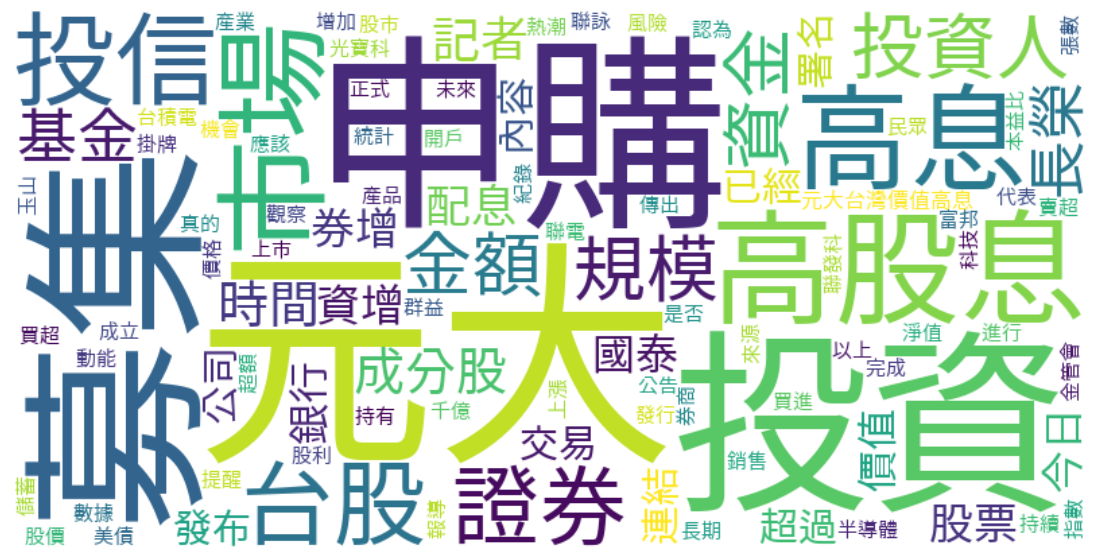

In [36]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('ETF', '00940', '940','原文','心得', '新聞', '情報', '標的', '原文標題', '原文連結', '發布時間', '記者署名', '原文內容', '心得/評論', '現在', '目前', '今年', '今天', 
                   '知道', '台灣', '分析/正文', '分類', '內文', '標題', '網址', '今天', '直接', '指出', '表示', '評論', '臺灣'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

結論: 藉由各式動詞，如「申購」、「投資」、「募集」等詞彙出現在正向文章中，可以知道多數文章對於元大相關的ETF申購有高度興趣、以及投資該元大相關證卷的關注度頗高，以及其募集活動備受關注。另外高股息、台股也是多數文章會提及的字彙。

## **3. 利用jieba進行前資料處理**

### 3.1 jieba斷詞、斷句處理 Code

In [74]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
FontPath = 'SourceHanSansTW-Regular.otf' # 設定字型

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

載入資料

In [38]:
df = pd.read_csv("../week3/raw_data/sna2024s_3_be156f6b2c_37.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 

資料清理

In [39]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

##### 斷句的部分增加「：」

In [40]:
clear_df['sentence'] = clear_df['sentence'].str.split("[：,，。！!？?]{1,}") #增加:：
sent_df = clear_df.explode('sentence').reset_index(drop=True)
sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文標題
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,元大臺灣價值高息ETF准募 3／11展開募集
2,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文連結
3,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,17:54
4,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,記者署名
5,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,工商時報 陳昱光
6,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文內容
7,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,元大投信26日取得證交所同意募集元大臺灣價值高息ETF證券投資信託基金（00940）
8,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,將於3月11日展開募集
9,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,國內ETF發行龍頭元大投信


初始化斷詞

In [41]:
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')
jieba.add_word('元大臺灣價值高息ETF')
jieba.add_word('TW元大台灣價值高息')
jieba.add_word('元大台灣價值高息ETF')
jieba.add_word('元大臺灣價值高息ETF證券投資信託基金')
jieba.add_word('高股息ETF')
jieba.add_word('臺灣價值高息ETF')
jieba.add_word('3/11展開募集')
jieba.add_word('3/11')
jieba.add_word('311')
jieba.add_word('自由現金流')

Building prefix dict from c:\Users\User\SMA_2024S - 複製\G3\dict\dict.txt ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.uc5015eca1e8d8a2de6c952d082a97bb2.cache
Loading model cost 0.695 seconds.
Prefix dict has been built successfully.


In [42]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

使用jieba進行斷詞

In [43]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文
0,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,標題
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,元大臺灣價值高息ETF
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,准募
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,311
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,展開
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,募集
2,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文
2,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,連結
3,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,1754


In [71]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_7060\36027799.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,00940,452
1,ETF,344
2,申購,223
3,元大,174
4,原文,174
5,投資,157
6,市場,137
7,配息,131
8,投信,130
9,募集,125


In [72]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

freq_dict

{'00940': 452,
 'ETF': 344,
 '申購': 223,
 '元大': 174,
 '原文': 174,
 '投資': 157,
 '市場': 137,
 '配息': 131,
 '投信': 130,
 '募集': 125,
 '長榮': 117,
 '投資人': 115,
 '台灣': 106,
 '就是': 99,
 '成分股': 98,
 '資金': 98,
 '可以': 94,
 '台股': 90,
 '高息': 89,
 '高股息': 89,
 '10': 87,
 '高股息ETF': 80,
 '現在': 79,
 '億元': 78,
 '證券': 77,
 '記者': 76,
 '標題': 74,
 '規模': 72,
 '金額': 71,
 '沒有': 70,
 '940': 67,
 '銀行': 66,
 '00939': 66,
 '開始': 65,
 '淨值': 65,
 '不是': 63,
 '上市': 62,
 '00919': 62,
 '連結': 61,
 '心得': 61,
 '內容': 60,
 '公司': 60,
 '股票': 60,
 '基金': 60,
 '定存': 58,
 '標的': 58,
 '15': 57,
 '如果': 57,
 '大家': 57,
 '股價': 57,
 '可能': 57,
 '所以': 56,
 '因為': 56,
 '超過': 56,
 '目前': 56,
 '價值': 52,
 '評論': 52,
 '長期': 51,
 '還有': 51,
 '統一': 51,
 '金管會': 50,
 '應該': 50,
 '指數': 49,
 '署名': 48,
 '指出': 47,
 '自己': 47,
 '動能': 47,
 '已經': 46,
 '股利': 46,
 '表示': 46,
 '進場': 45,
 '還是': 45,
 '這樣': 44,
 '是否': 42,
 '今年': 42,
 '真的': 42,
 '風險': 42,
 '一下': 41,
 '今天': 41,
 '很多': 41,
 '券商': 39,
 '11': 38,
 '不過': 38,
 '殖利率': 38,
 '以上': 38,
 '未來': 38,
 '開戶': 37,
 '一樣': 37,

### 3.2 初步斷詞、斷句結果 : 文字雲 & 後續處理

#### 文字雲

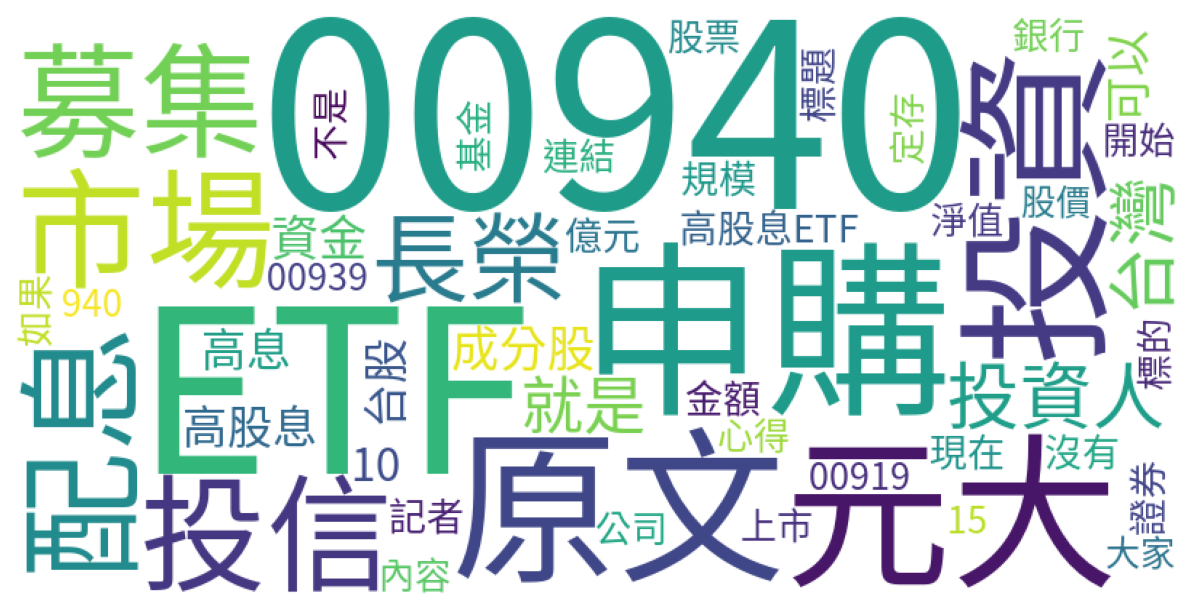

In [75]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

結論:【停用字原因】
+ 由於是在ppt發文，標題包括「心得」、「新聞」、「情報」、「標的」等類別，因此這些詞要移除
+ 轉貼新聞時內文有固定格式，需移除的字包括「原文標題」、「原文連結」、「發布時間」、「記者署名」、「原文內容」、「心得/評論」
+ 其他行文常用詞：「不是」、「就是」、「沒有」、「如果」、「台灣」、「網址」、「今天」等
+ 有關ETF本身的資訊：「ETF」、「00940」、「940」

#### 後續處理 : 移除停用字

In [76]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
# 其他停用字列表
other_stopwords = ['ETF', '00940', '940', '心得', '新聞', '情報', '標的', '原文標題', '原文連結', '發布時間', '記者署名', '原文內容', '心得/評論', '現在', '目前', '今年', '今天', 
                   '知道', '台灣', '分析/正文', '分類', '內文', '標題', '網址', '今天', '直接', '指出', '表示', '評論', '臺灣']
# 合併停用字列表
stopwords.extend(other_stopwords)

In [77]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,元大臺灣價值高息ETF
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,准募
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,311
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,展開
...,...,...,...,...,...
5527,https://www.ptt.cc/bbs/Stock/M.1710864008.A.C6...,Re:[新聞]00939淨值為15.11元明日掛牌上市！40檔,2024-03-20,想請問大家關於成分股的占比\n\n根據此篇新聞，531億的規模長榮佔4.4趴，這樣00939...,發行
5527,https://www.ptt.cc/bbs/Stock/M.1710864008.A.C6...,Re:[新聞]00939淨值為15.11元明日掛牌上市！40檔,2024-03-20,想請問大家關於成分股的占比\n\n根據此篇新聞，531億的規模長榮佔4.4趴，這樣00939...,元大
5527,https://www.ptt.cc/bbs/Stock/M.1710864008.A.C6...,Re:[新聞]00939淨值為15.11元明日掛牌上市！40檔,2024-03-20,想請問大家關於成分股的占比\n\n根據此篇新聞，531億的規模長榮佔4.4趴，這樣00939...,進場
5527,https://www.ptt.cc/bbs/Stock/M.1710864008.A.C6...,Re:[新聞]00939淨值為15.11元明日掛牌上市！40檔,2024-03-20,想請問大家關於成分股的占比\n\n根據此篇新聞，531億的規模長榮佔4.4趴，這樣00939...,成分股


## **4. Lexicon-based 情緒分析**


### 4.1 正負向情緒分析


#### 正負向情緒分析 Code

進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

準備LIWC字典

In [51]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

In [52]:
#情緒字典與斷詞結果進行合併
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,2024-01-26,[新聞]元大臺灣價值高息ETF准募3／11展開募集,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,原文,NaN
1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,2024-01-26,[新聞]元大臺灣價值高息ETF准募3／11展開募集,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,元大臺灣價值高息ETF,NaN
2,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,2024-01-26,[新聞]元大臺灣價值高息ETF准募3／11展開募集,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,准募,NaN
3,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,2024-01-26,[新聞]元大臺灣價值高息ETF准募3／11展開募集,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,311,NaN
4,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,2024-01-26,[新聞]元大臺灣價值高息ETF准募3／11展開募集,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,展開,NaN


#### 正負向情緒分析結果 : 詞彙頻率折線圖

In [53]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])

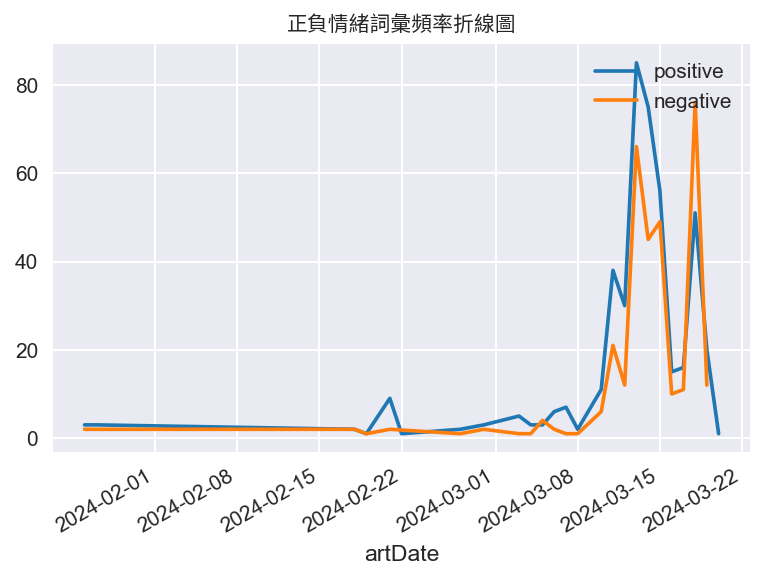

In [54]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

結論: 初期在股票版討論00940時，正負面詞彙的使用無太大的起伏，直到申購日(3/11)開始先是出現大量的正面詞彙，又急速下降至被負面詞彙的數量所超越。

### 4.2 單一文章情緒分析

#### 單一文章情緒分析 Code

In [55]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})

ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)

ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )

clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

In [56]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2024-01-26,正向,1
1,2024-01-27,正向,1
2,2024-02-18,負向,1
3,2024-02-19,負向,1
4,2024-02-21,正向,1
5,2024-02-22,正向,1
6,2024-02-27,正向,1
7,2024-02-29,正向,1
8,2024-02-29,負向,1
9,2024-03-03,正向,1


#### 單一文章情緒分析結果 : 正負文章趨勢折線圖

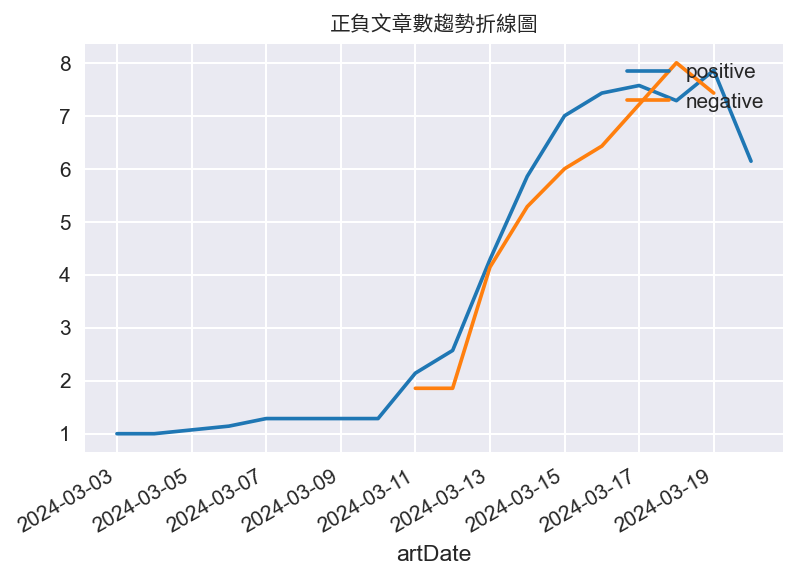

In [57]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生近 7 天平均
rolling_days = 7
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

結論: 初期文章在股票版討論00940時，都被歸類在正向文章，內容大多偏正面；
從申購日(3/11)開始逐漸出現負面文章，內容大多偏向負面，甚至超越正向文章的數量。

### 4.3 情緒代表字分析

#### 情緒代表字分析 Code

In [58]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

In [59]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

去除不符合文本的情緒

In [60]:
# 設定要移除的字詞列表
words_to_remove = ['朋友','重要','成功','分享','容易','保證','有錢','歡迎','希望','解決','強勢','瘋狂','詐騙','想像','肯定','挑戰','爆發']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")

#### 情緒代表字分析結果 : 情緒代表字長條圖

C:\Users\User\AppData\Local\Temp\ipykernel_7060\1465679712.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\User\AppData\Local\Temp\ipykernel_7060\1465679712.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

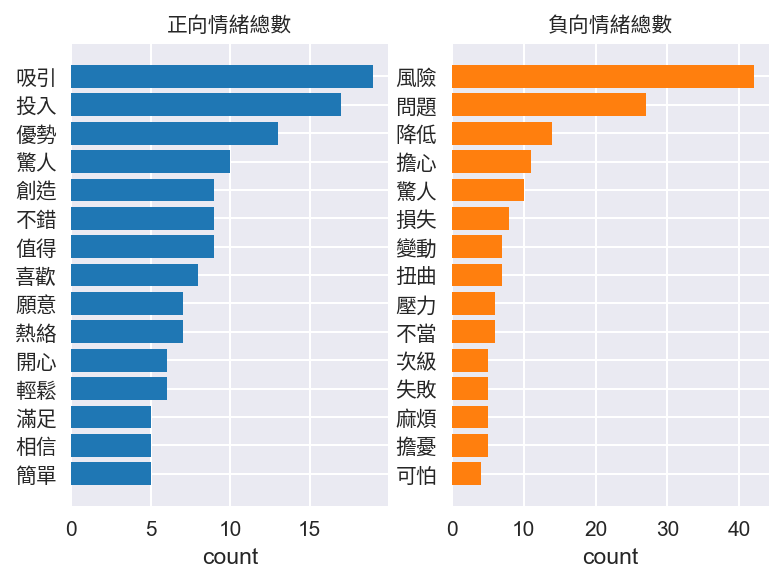

In [61]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 4.4 負面詞彙

#### 負面詞彙分析 Code

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [62]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

In [63]:
date = "2024-01-01"
end_date = "2024-03-20"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
631,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,元大,NaN,負向
632,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,募集,NaN,負向
633,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,高股息ETF,NaN,負向
634,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,發行價,NaN,負向
635,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,10,NaN,負向


In [64]:
date = "2024-01-01"
end_date = "2024-03-20"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
631,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,元大,NaN,負向
632,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,募集,NaN,負向
633,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,高股息ETF,NaN,負向
634,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,發行價,NaN,負向
635,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,2024-02-18,[請益]00940的選股邏輯,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,10,NaN,負向


In [65]:
date = "2024-01-01"
end_date = "2024-03-20"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
2384,申購,95
3471,風險,87
1086,原文,77
1761,投資人,75
865,元大,70
...,...,...
1368,太扯了,1
1369,太火,1
1370,太熱,1
1371,太爛,1


#### 負面詞彙分析結果 :文字雲

(-0.5, 399.5, 199.5, -0.5)

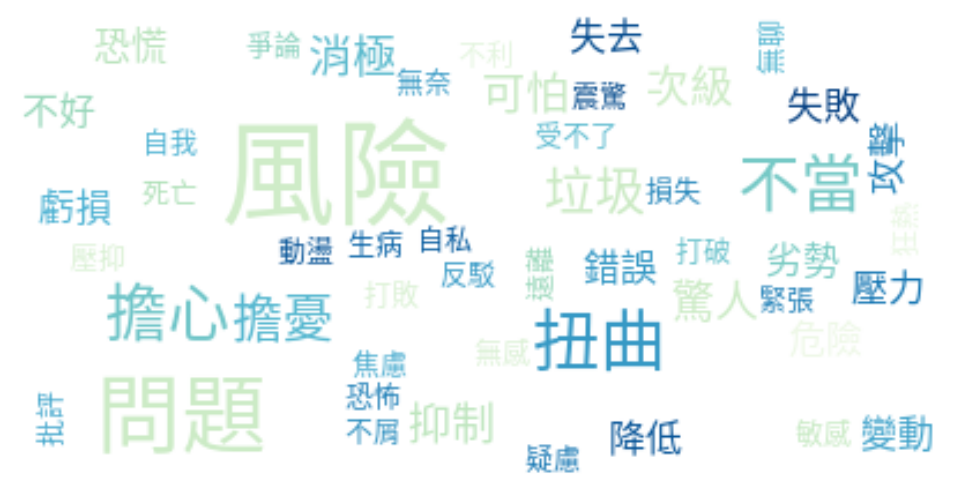

In [66]:
date = "2024-01-01"
end_date = "2024-03-20"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('投資人')) & ( # 內文包含投資人
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=50, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()